# Recurrent Neural Networks for Stock Price Prediction

The following Recurrent Neural Networks are explored for Google Stock Price prediction.
* RNN
* LSTM
* GRU

In [1]:
!pip install pandas_market_calendars
# Import libraries.
import kagglehub
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas_market_calendars as mcal
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchmetrics.functional import r2_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.1/108.1 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.8/196.8 kB 9.0 MB/s eta 0:00:00


In [2]:
seed = 42
np.random.seed(seed)

# Set seed for PyTorch.
torch.manual_seed(seed)

# Set seed for inbuilt random function.
random.seed(seed)

# Use Metal GPU.
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# Increase DPI for plots.
plt.rcParams['figure.dpi'] = 500

In [34]:
# Download and load the dataset
base_path = kagglehub.dataset_download("rahulsah06/gooogle-stock-price")
train_path = f"{base_path}/Google_Stock_Price_Train.csv"
test_path = f"{base_path}/Google_Stock_Price_Test.csv"
df = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
print("Training dataset size:", df.shape)
print("Testing dataset size:", df_test.shape)

Training dataset size: (1258, 6)
Testing dataset size: (20, 6)


## Exploratory Data Analysis & Data Pre-processing

In [35]:
# Convert date to month/date/year format.
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')
df_test['Date'] = pd.to_datetime(df_test['Date'], format='%m/%d/%Y')

print(f"Training dataset dates: {df['Date'].min()} - {df['Date'].max()}")
print(f"Testing dataset dates: {df_test['Date'].min()} - {df_test['Date'].max()}")
df.head(n=15)

Training dataset dates: 2012-01-03 00:00:00 - 2016-12-30 00:00:00
Testing dataset dates: 2017-01-03 00:00:00 - 2017-01-31 00:00:00


Date    Open    High     Low   Close      Volume
0  2012-01-03  325.25  332.83  324.97  663.59   7,380,500
1  2012-01-04  331.27  333.87  329.08  666.45   5,749,400
2  2012-01-05  329.83  330.75  326.89  657.21   6,590,300
3  2012-01-06  328.34  328.77  323.68  648.24   5,405,900
4  2012-01-09  322.04  322.29  309.46  620.76  11,688,800
5  2012-01-10  313.70  315.72  307.30  621.43   8,824,000
6  2012-01-11  310.59  313.52  309.40  624.25   4,817,800
7  2012-01-12  314.43  315.26  312.08  627.92   3,764,400
8  2012-01-13  311.96  312.30  309.37  623.28   4,631,800
9  2012-01-17  314.81  314.81  311.67  626.86   3,832,800
10 2012-01-18  312.14  315.82  309.90  631.18   5,544,000
11 2012-01-19  319.30  319.30  314.55  637.82  12,657,800
12 2012-01-20  294.16  294.40  289.76  584.39  21,231,800
13 2012-01-23  291.91  293.23  290.49  583.92   6,851,300
14 2012-01-24  292.07  292.74  287.92  579.34   6,134,400

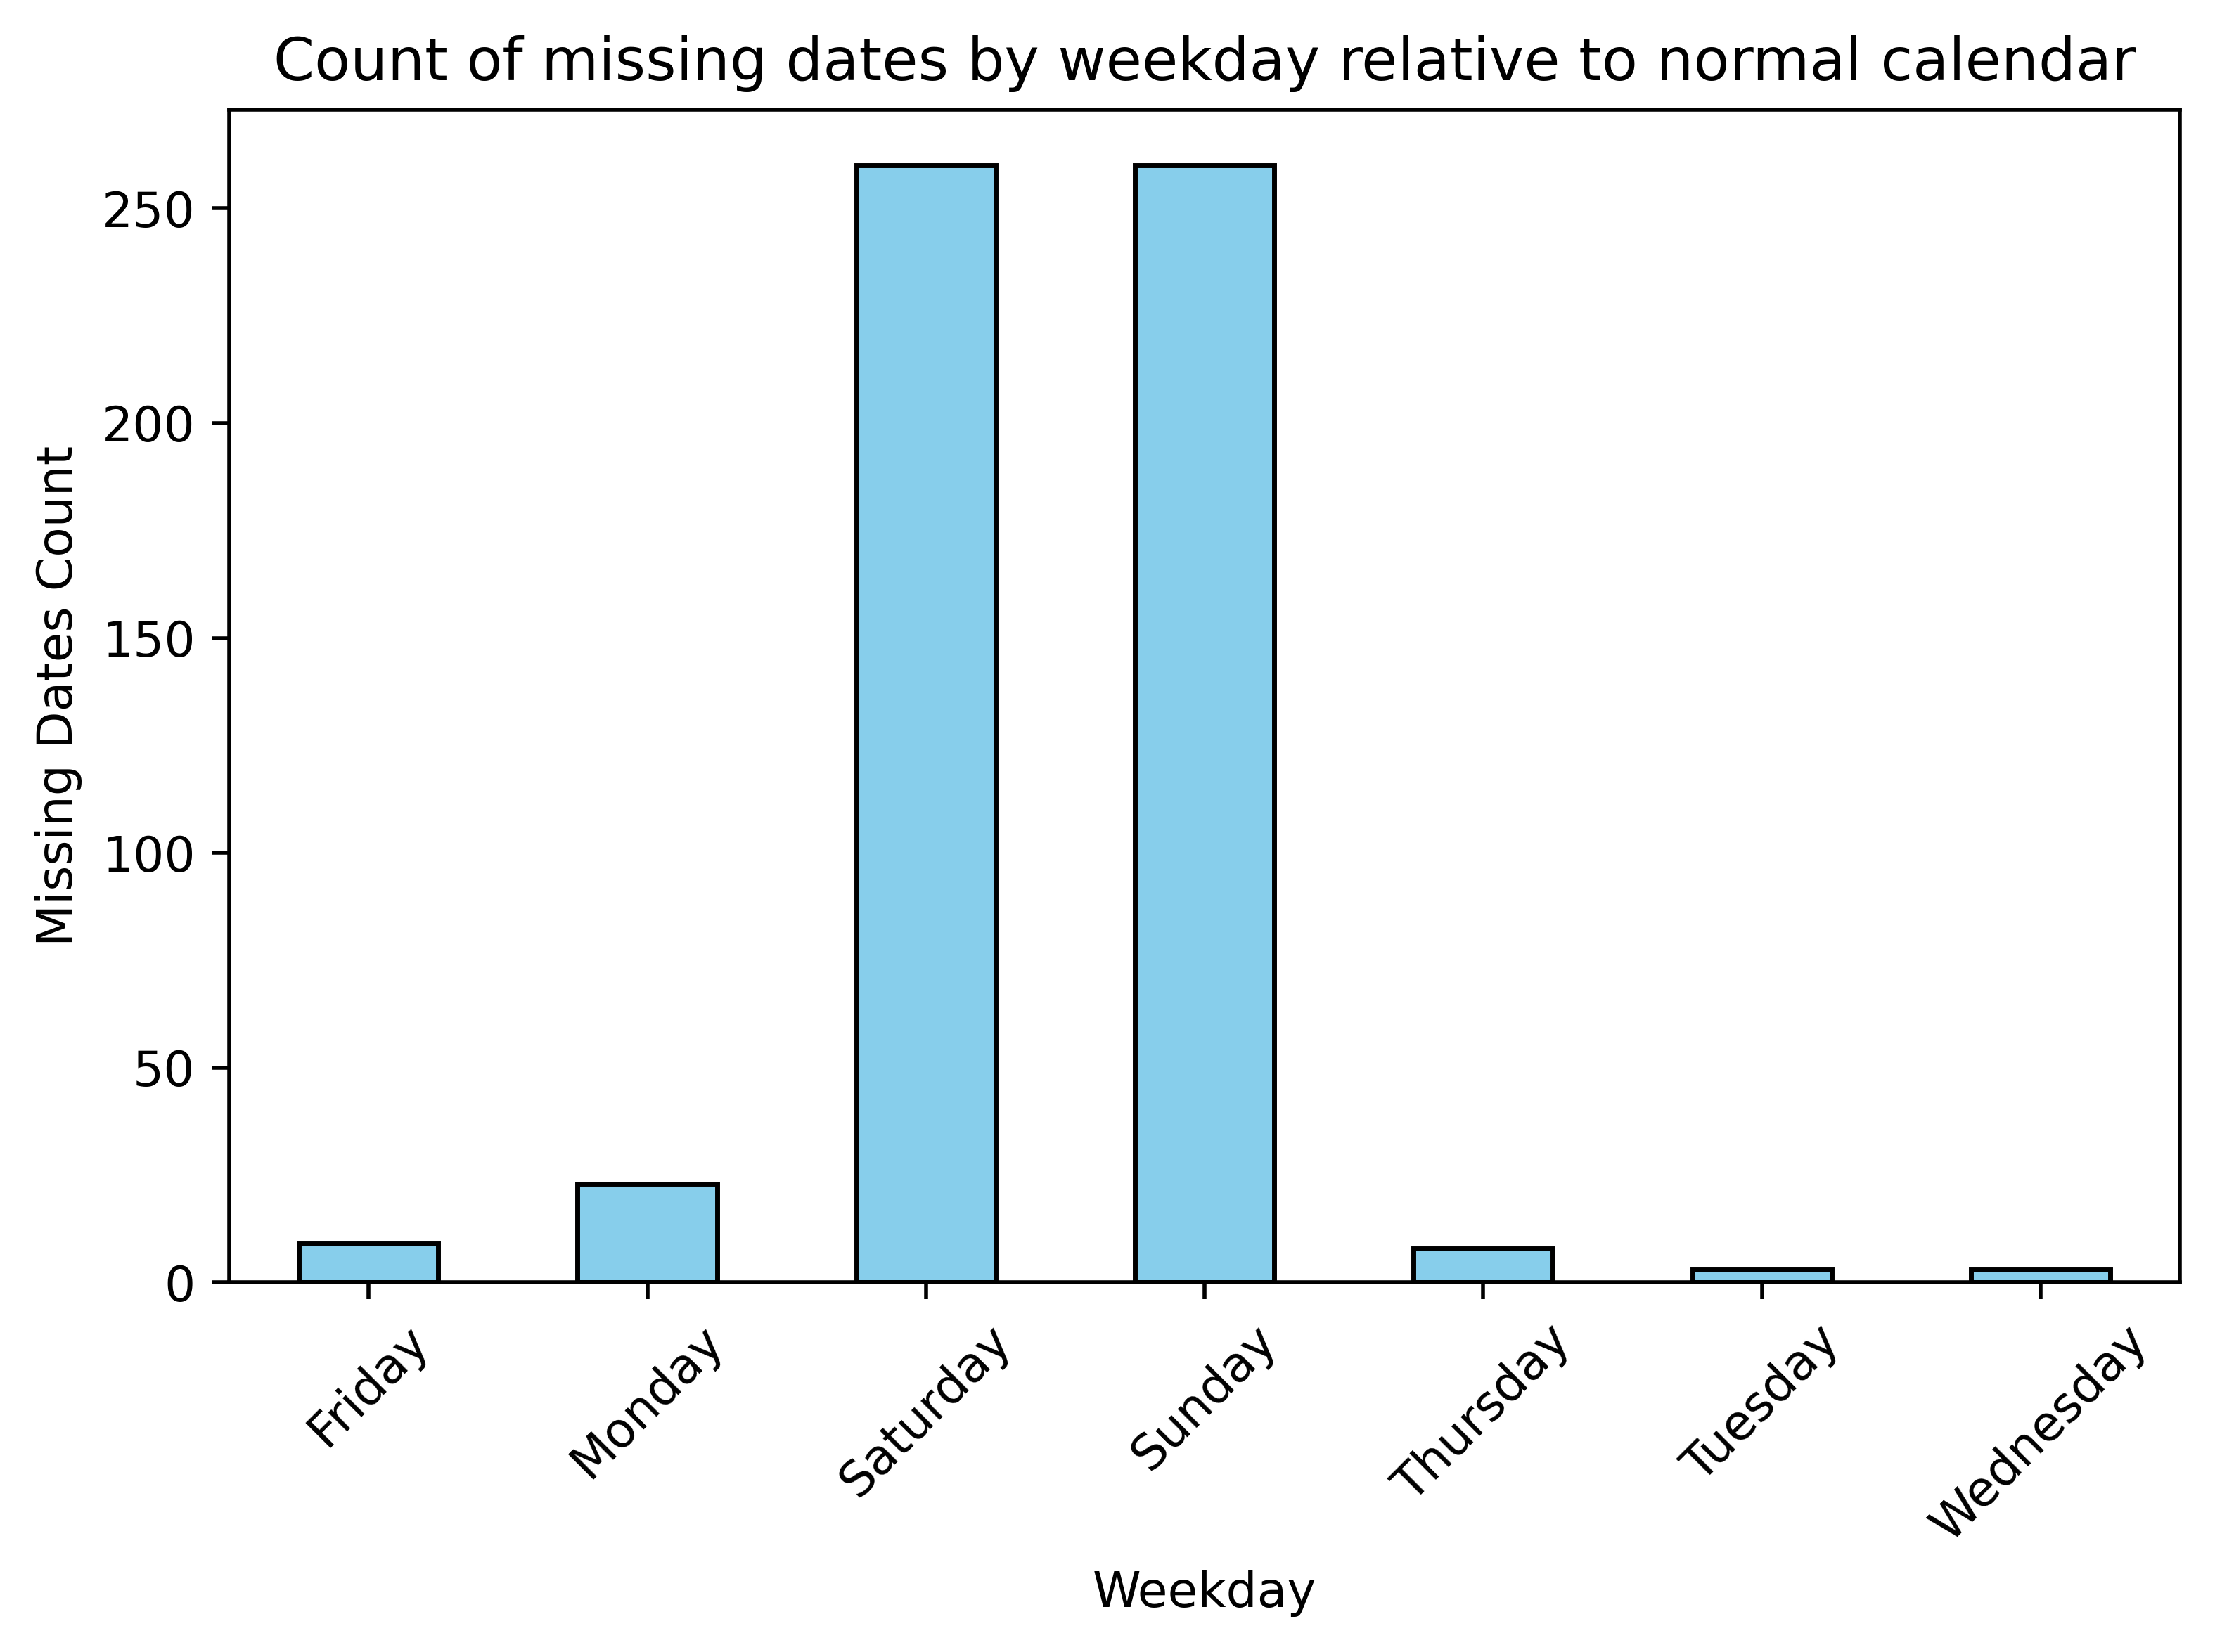

In [5]:
# Count the missing dates
full_date_range = pd.date_range(start=df['Date'].min(), end=df['Date'].max())
missing_dates = full_date_range.difference(df['Date'])
missing_dates_df = pd.DataFrame({'Date': missing_dates})
missing_dates_df['Weekday'] = missing_dates_df['Date'].dt.day_name()

# Count missing dates by weekday
weekday_counts = missing_dates_df['Weekday'].value_counts()

# Plot the counts in a bar chart
weekday_counts.sort_index(inplace=True)  # Sort by weekday order
weekday_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Count of missing dates by weekday relative to normal calendar')
plt.xlabel('Weekday')
plt.ylabel('Missing Dates Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Count the missing dates relative to the financial calendar.
nyse = mcal.get_calendar('NYSE')
schedule = nyse.schedule(start_date=df['Date'].min(), end_date=df['Date'].max())

# Generate a list of valid market days
valid_market_days = schedule.index

# Identify missing market days
missing_market_days = valid_market_days.difference(df['Date'])

# Convert to DataFrame for analysis
missing_days_df = pd.DataFrame({'Missing Dates': missing_market_days})
missing_days_df['Weekday'] = missing_days_df['Missing Dates'].dt.day_name()

# Output
print("Missing Market Days:")
print(missing_days_df)

Missing Market Days:
Empty DataFrame
Columns: [Missing Dates, Weekday]
Index: []


### Implication of missing dates
- When comparing the continuity of dates with the normal calendar, some dates are missing. However, it matches with the financial calendar.
- Some dates are missing since the financial market is closed on weekends and public holidays.
- These dates can be backfilled with data from previous dates.
- While predicting, additional checks are essential to account for market holidays.

In [7]:
# Backfill missing dates data.
# Set 'Date' as index
df.set_index('Date', inplace=True)

# Generate the complete date range
full_date_range = pd.date_range(start=df.index.min(), end=df.index.max())

# Reindex the DataFrame to include all dates
df = df.reindex(full_date_range)

# Backfill missing rows with the previous day's data
df = df.bfill()

# Reset the index and rename columns
df.reset_index(inplace=True)
df.rename(columns={'index': 'Date'}, inplace=True)


In [8]:
df_test.set_index('Date', inplace=True)

# Generate the complete date range.
full_date_range = pd.date_range(start=df_test.index.min(), end=df_test.index.max())

# Reindex the DataFrame to include all dates.
df_test = df_test.reindex(full_date_range)

# Backfill missing rows with the previous day's data.
df_test = df_test.bfill()

# Reset the index and rename columns
df_test.reset_index(inplace=True)
df_test.rename(columns={'index': 'Date'}, inplace=True)

In [9]:
print("Training dataset size after backfilling:", df.shape)
print("Testing dataset size backfilling:", df_test.shape)

print(f"Training dataset dates: {df['Date'].min()} - {df['Date'].max()}")
print(f"Testing dataset dates: {df_test['Date'].min()} - {df_test['Date'].max()}")

Training dataset size after backfilling: (1824, 6)
Testing dataset size backfilling: (29, 6)
Training dataset dates: 2012-01-03 00:00:00 - 2016-12-30 00:00:00
Testing dataset dates: 2017-01-03 00:00:00 - 2017-01-31 00:00:00


In [10]:
df.head(n=15)

Date    Open    High     Low   Close      Volume
0  2012-01-03  325.25  332.83  324.97  663.59   7,380,500
1  2012-01-04  331.27  333.87  329.08  666.45   5,749,400
2  2012-01-05  329.83  330.75  326.89  657.21   6,590,300
3  2012-01-06  328.34  328.77  323.68  648.24   5,405,900
4  2012-01-07  322.04  322.29  309.46  620.76  11,688,800
5  2012-01-08  322.04  322.29  309.46  620.76  11,688,800
6  2012-01-09  322.04  322.29  309.46  620.76  11,688,800
7  2012-01-10  313.70  315.72  307.30  621.43   8,824,000
8  2012-01-11  310.59  313.52  309.40  624.25   4,817,800
9  2012-01-12  314.43  315.26  312.08  627.92   3,764,400
10 2012-01-13  311.96  312.30  309.37  623.28   4,631,800
11 2012-01-14  314.81  314.81  311.67  626.86   3,832,800
12 2012-01-15  314.81  314.81  311.67  626.86   3,832,800
13 2012-01-16  314.81  314.81  311.67  626.86   3,832,800
14 2012-01-17  314.81  314.81  311.67  626.86   3,832,800

In [11]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close             object
Volume            object
dtype: object

In [12]:
df_test.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume            object
dtype: object

### Data type inference
- Need to convert Close and Volume columns to float data type for computation.

In [13]:
df['Close'] = df['Close'].apply(lambda x : x.replace(',', '')).astype('float')
df['Volume'] = df['Volume'].apply(lambda x : x.replace(',', '')).astype('float')
df_test['Volume'] = df_test['Volume'].apply(lambda x : x.replace(',', '')).astype('float')

In [14]:
df.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

In [15]:
df_test.dtypes

Date      datetime64[ns]
Open             float64
High             float64
Low              float64
Close            float64
Volume           float64
dtype: object

### Data visualisation

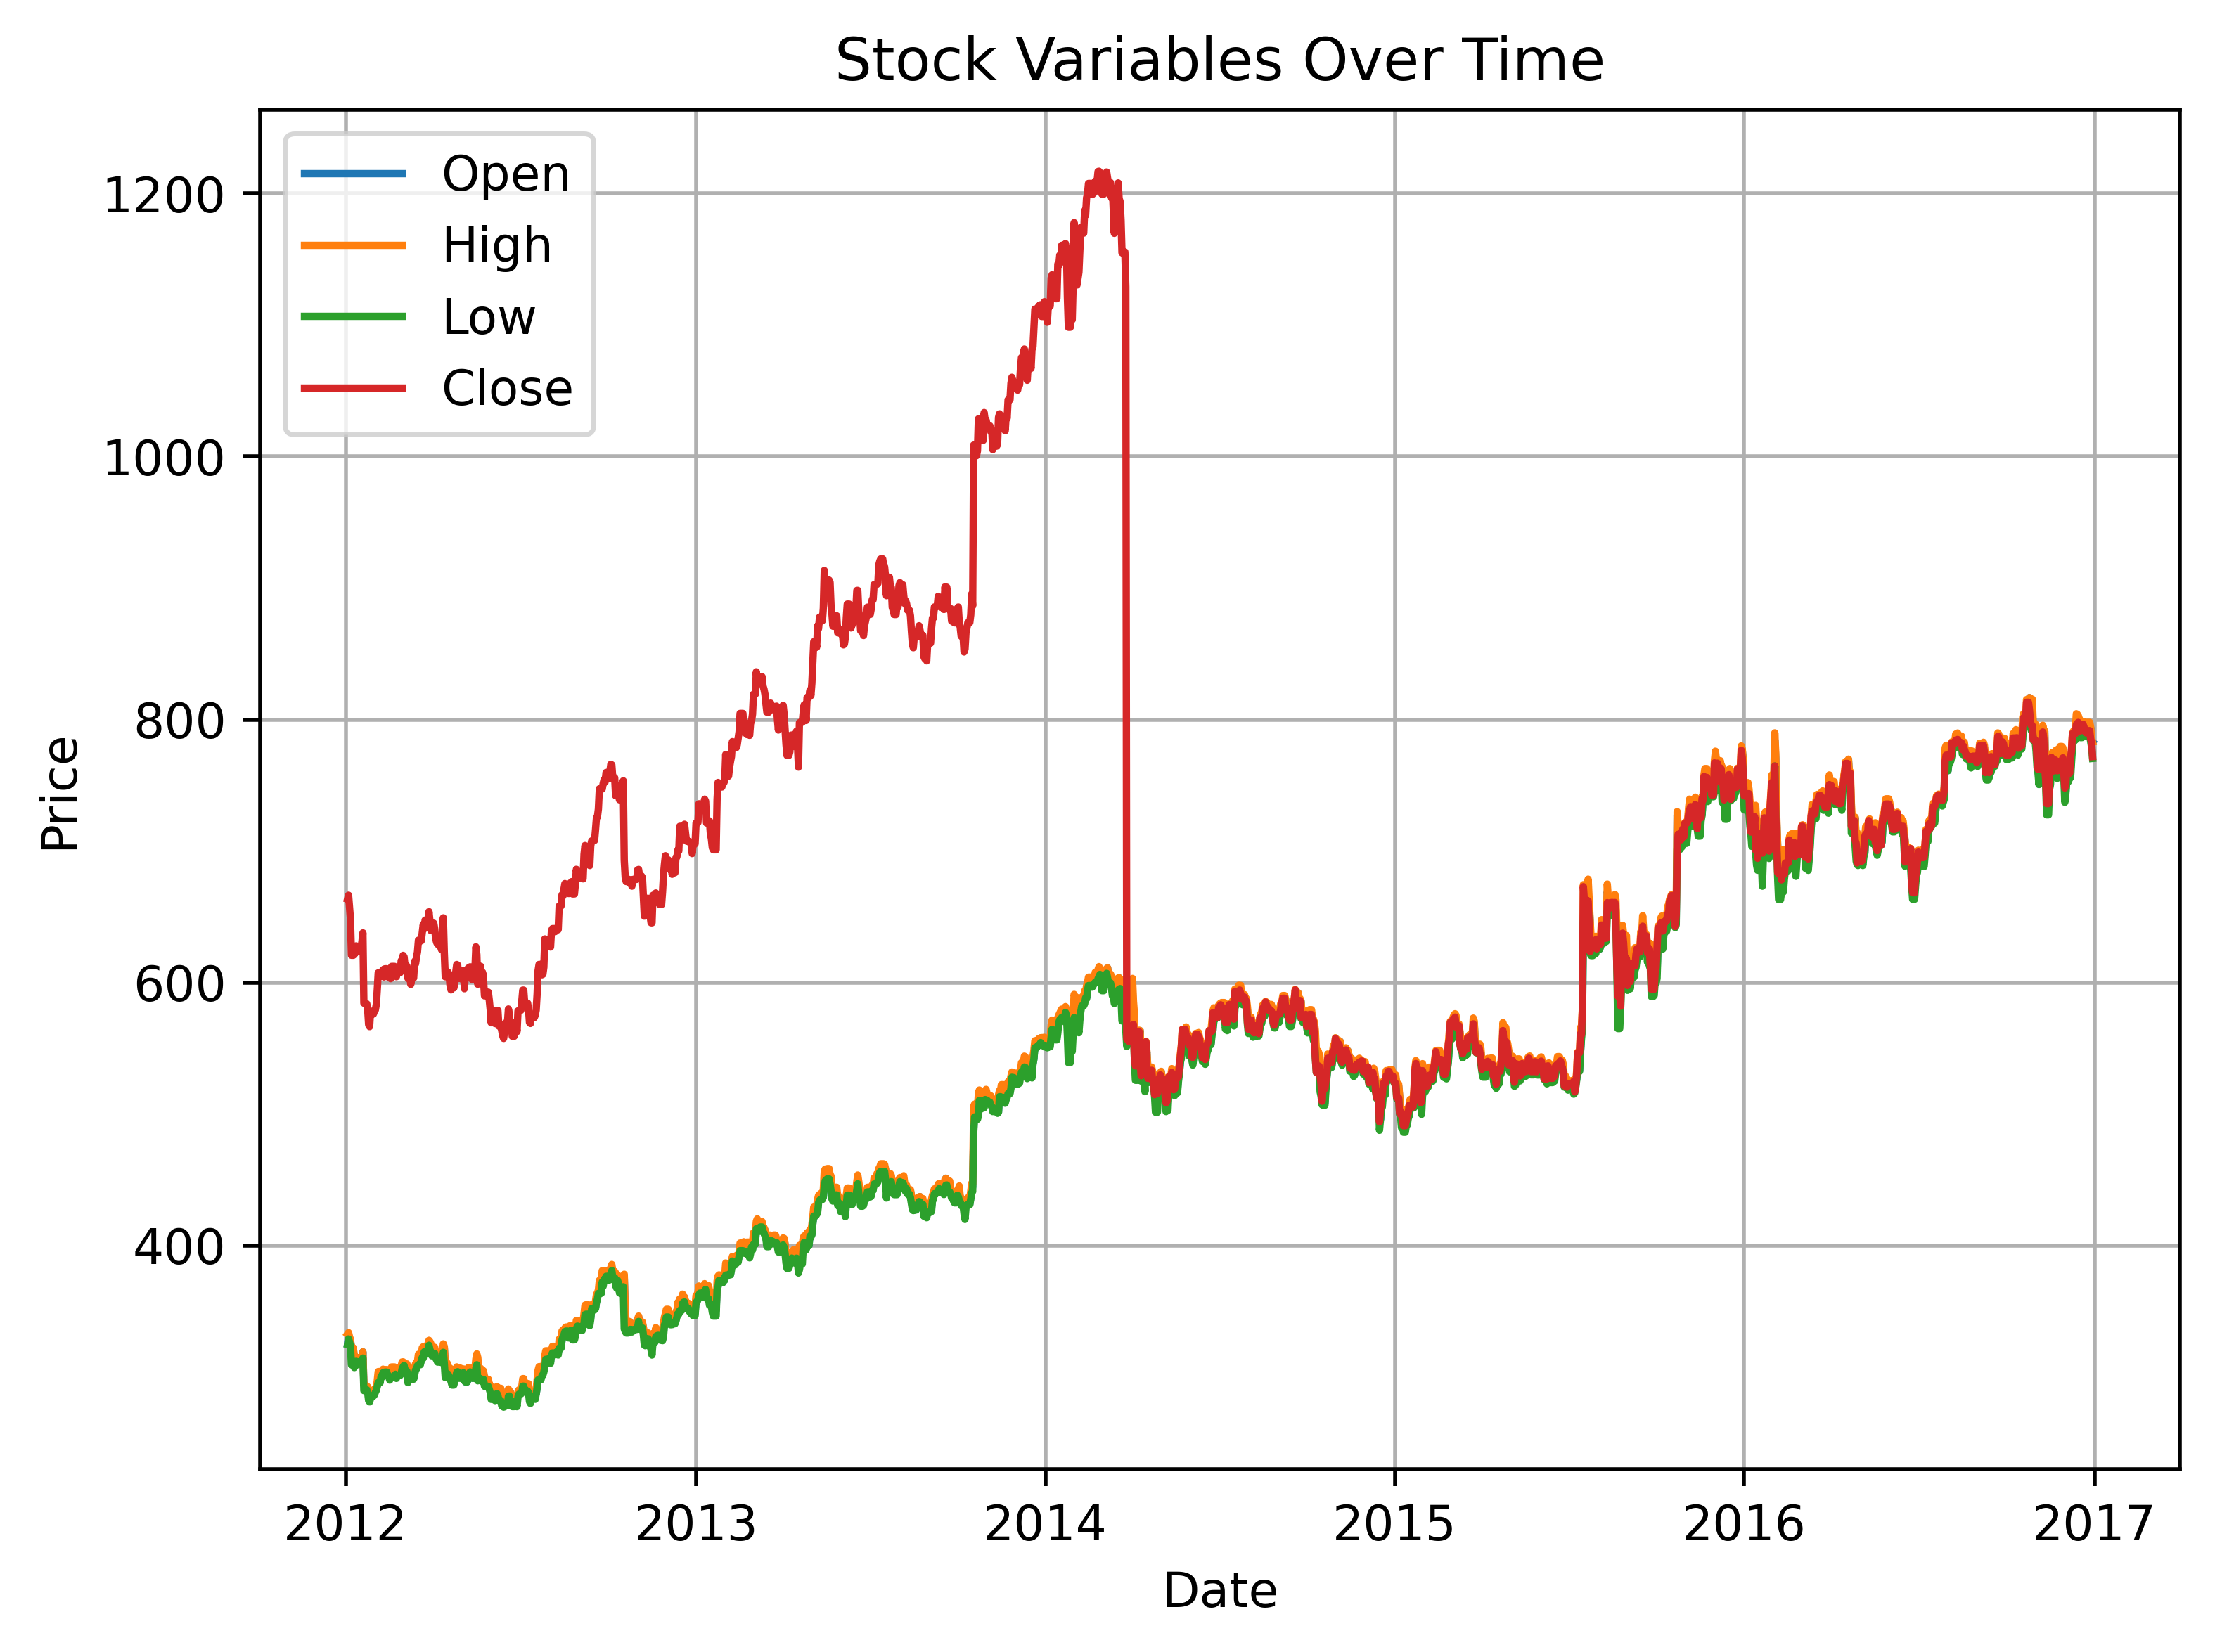

In [16]:
# Visualise Stock variables and their variations over time.
for column in df.drop(['Date', 'Volume'], axis=1).columns:
    plt.plot(df['Date'], df[column], label=column)

plt.title('Stock Variables Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()

plt.show()

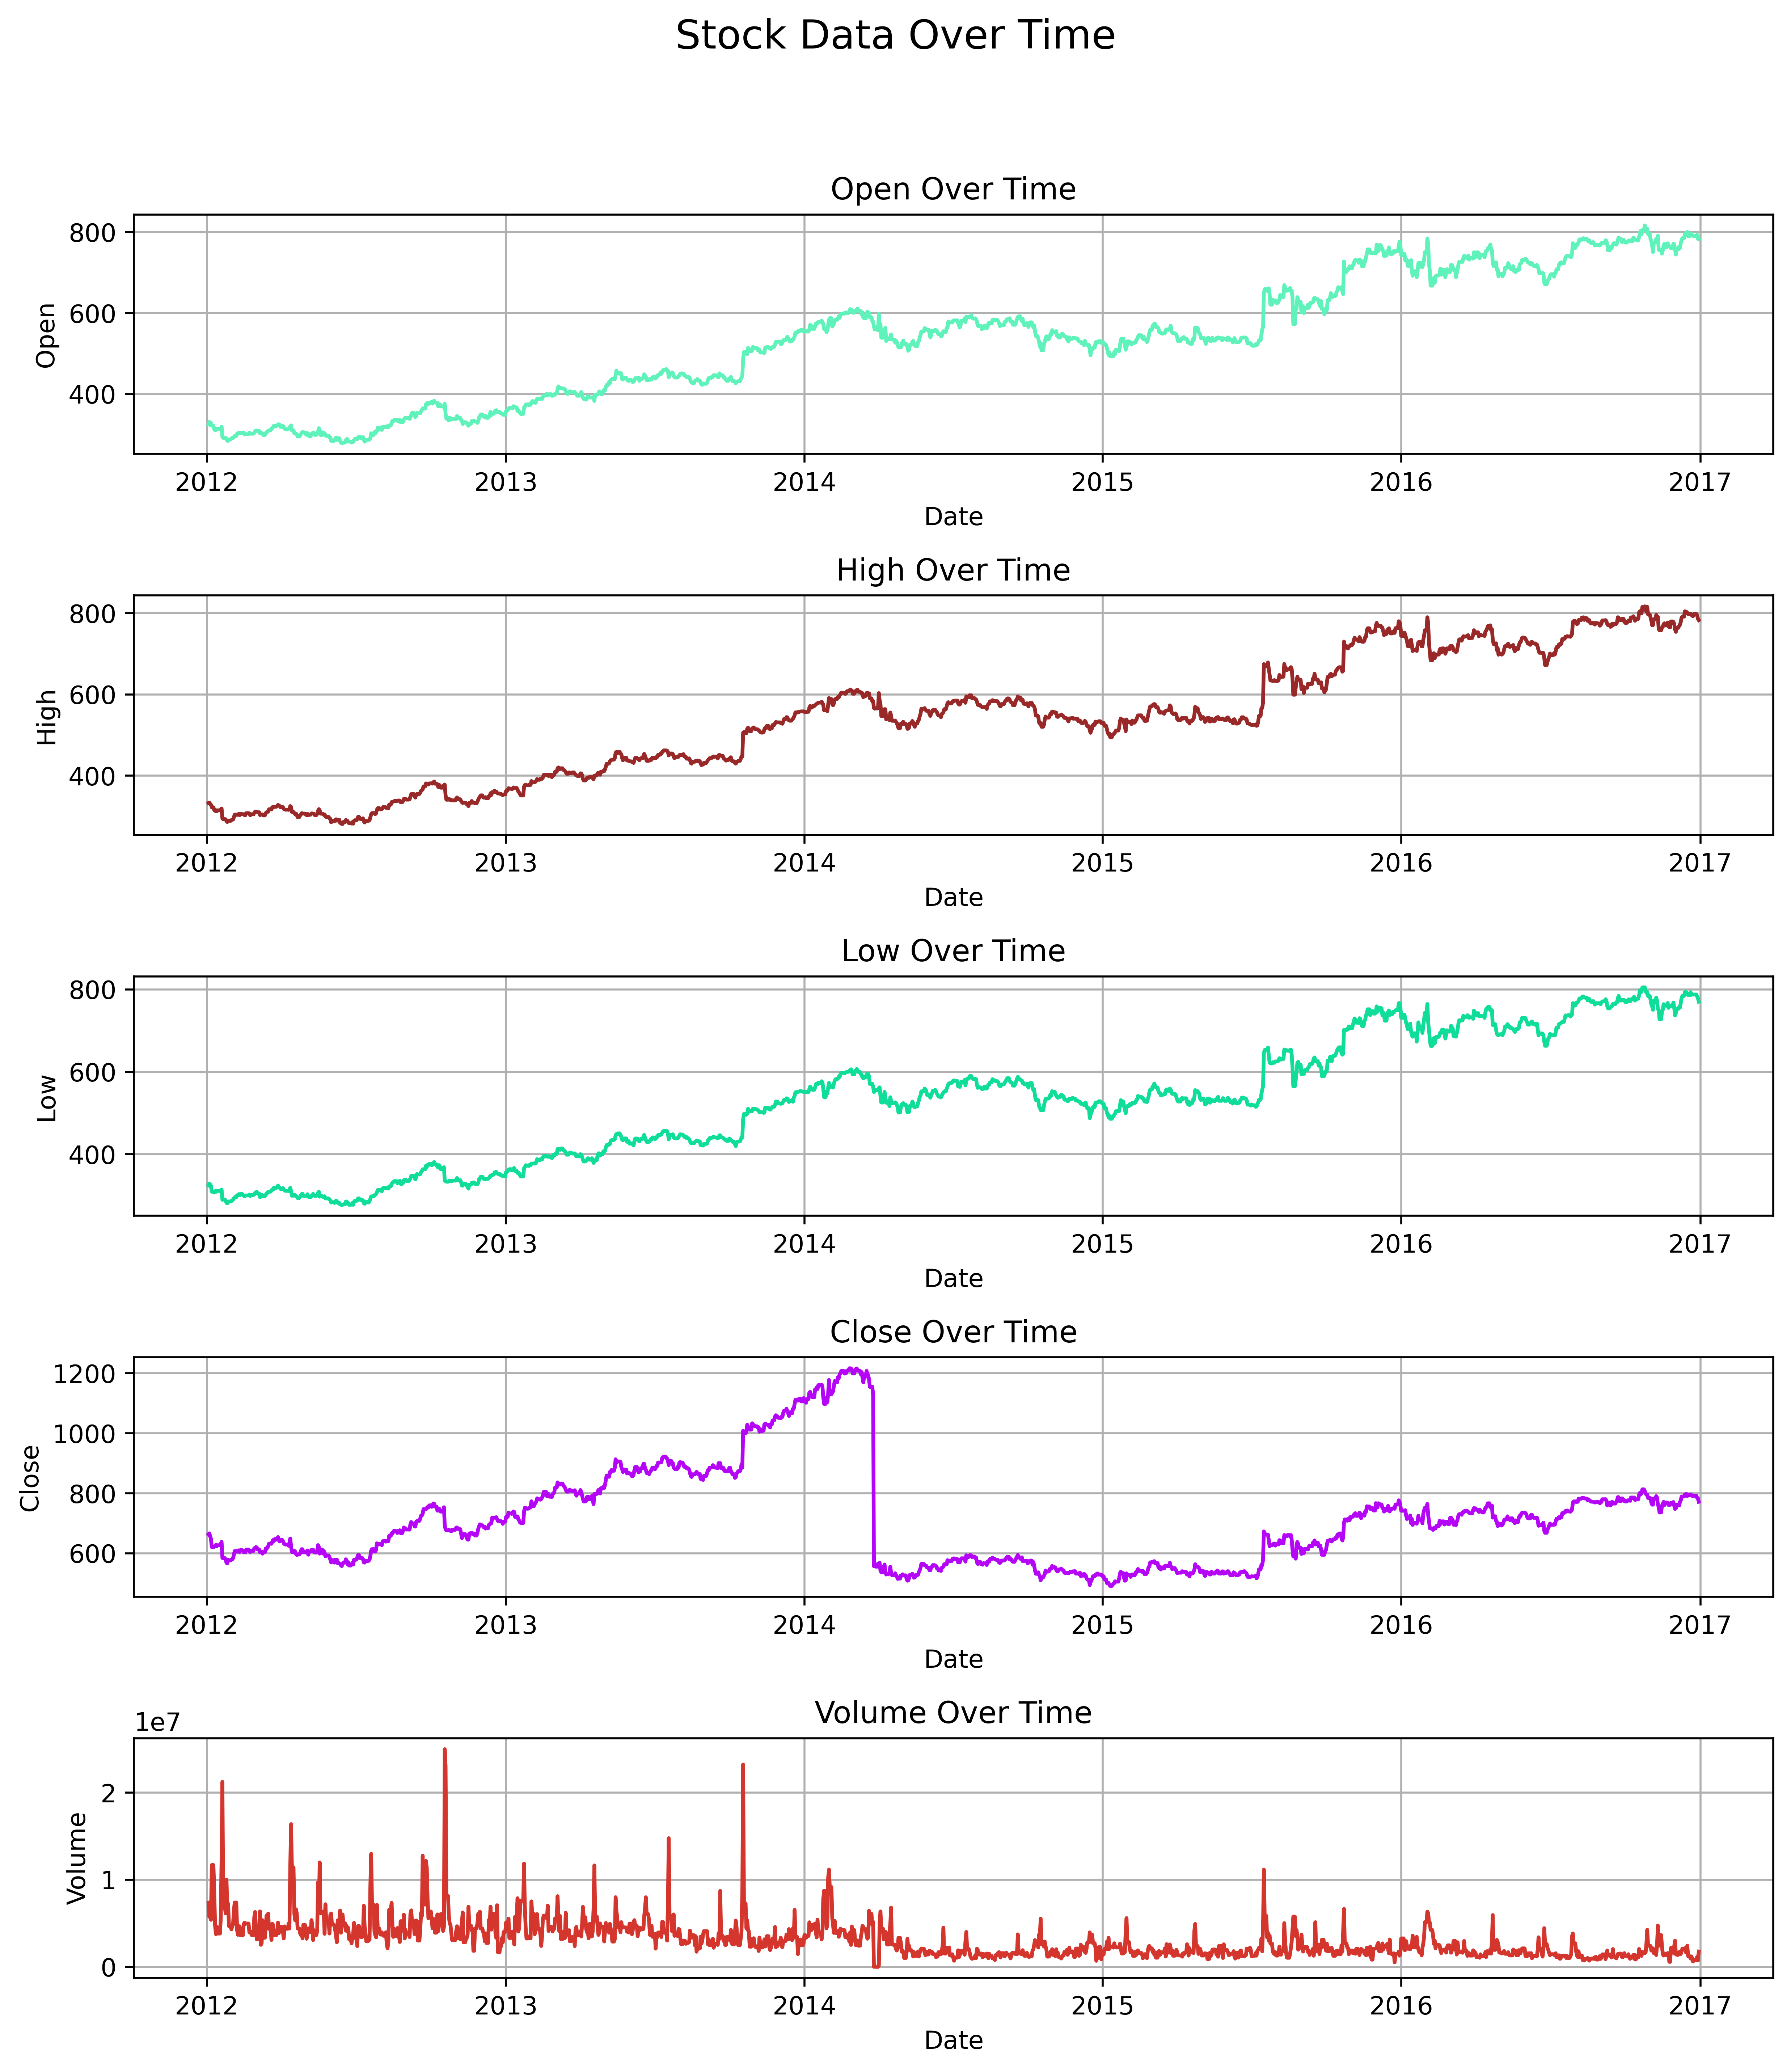

In [17]:
# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 12), sharex=False)

# Plot each variable
variables = ['Open', 'High', 'Low', 'Close', 'Volume']
for i, var in enumerate(variables):
    axes[i].plot(df['Date'], df[var], label=var, color=np.random.rand(3,))
    axes[i].set_title(f'{var} Over Time')
    axes[i].set_ylabel(var)
    axes[i].grid(True)
    axes[i].set_xlabel('Date')

fig.suptitle('Stock Data Over Time', fontsize=16)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Open, High, and Low variables have a similar pattern
- The pattern of the Close variable deviates around the year 2014.
- Volume variable has a fluctuating pattern.

### Data distribution

In [18]:
df.describe()

Date         Open         High          Low  \
count                 1824  1824.000000  1824.000000  1824.000000   
mean   2014-07-02 12:00:00   533.072083   537.340543   528.480729   
min    2012-01-03 00:00:00   279.120000   281.210000   277.220000   
25%    2013-04-02 18:00:00   401.150000   406.047500   400.000000   
50%    2014-07-02 12:00:00   537.135000   540.675000   532.400000   
75%    2015-10-01 06:00:00   654.747500   661.380000   644.400000   
max    2016-12-30 00:00:00   816.680000   816.680000   805.140000   
std                    NaN   151.733497   152.865305   150.459229   

             Close        Volume  
count  1824.000000  1.824000e+03  
mean    712.720367  3.106657e+06  
min     491.200000  7.900000e+03  
25%     576.920000  1.600625e+06  
50%     695.160000  2.529300e+06  
75%     781.760000  4.097750e+06  
max    1216.830000  2.497790e+07  
std     165.090467  2.144911e+06

- The data need to be normalised for uniformity across all variables.
- The date variable cannot be used as is. It can be transformed to timestamp.

In [19]:
# Obtain timestamp from Date value.
df['Timestamp'] = df['Date'].astype('int64') // 10**9
df_test['Timestamp'] = df_test['Date'].astype('int64') // 10**9

In [20]:
# Normalize the data using the MinMax scalar.
df = df[['Date', 'Close']]
df_test = df_test[['Date', 'Close']]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_df = scaler.fit_transform(df.drop('Date', axis=1).values)
scaled_df_test = scaler.transform(df_test.drop('Date', axis=1).values)

### Convert data to sequence

In [21]:
# Function to create a dataset with time steps denoting window size defaults to 10.
def create_dataset(data, time_step=10):
    X, y = [], []
    for i in range(time_step, len(data)):
        X.append(data[i-time_step:i])
        y.append(data[i])
    return np.array(X), np.array(y)

# Create datasets
X_train, y_train = create_dataset(scaled_df)
X_test, y_test = create_dataset(scaled_df_test)

features = df.drop('Date', axis=1).columns

In [22]:
# Convert the data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

## Modeling

In [23]:
# Model definitions
class RNNModel(nn.Module):
    """
    RNN model with the following parameters:
    input_size:  No of input features.
    hidden_size: Hidden layer dimension of each RNN layer.
    num_layers:  No of RNN layers stacked together.
    output_size: Number of output predicted.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialise the basic building blocks and layers.
        """
        super(RNNModel, self).__init__()
        # Stack num_layers of RNNs.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Three dense layers.
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        # Leaky ReLU activation for each dense layer output.
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.001)
        # Batch normalisation for each dense layer.
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size // 4)
    
    def forward(self, x):
        """
        Feedforward the input data.
        """
        out, _ = self.rnn(x)
        out = out[:, -1, :]
        out = self.fc1(self.leaky_relu(self.batch_norm1(out)))
        out = self.fc2(self.leaky_relu(self.batch_norm2(out)))
        out = self.fc3(self.leaky_relu(self.batch_norm3(out)))
        return out

class LSTMModel(nn.Module):
    """
    LSTM model with the following parameters:
    input_size:  No of input features.
    hidden_size: Hidden layer dimension of each LSTM layer.
    num_layers:  No of LSTM layers stacked together.
    output_size: Number of output predicted.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialise the basic building blocks and layers.
        """
        super(LSTMModel, self).__init__()
        # Stack num_layers of LSTMs.
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Three dense layers.
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        # Leaky ReLU activation for each dense layer output.
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.001)
        # Batch normalisation for each dense layer.
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size // 4)
    
    
    def forward(self, x):
        """
        Feedforward the input data.
        """
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.fc1(self.leaky_relu(self.batch_norm1(out)))
        out = self.fc2(self.leaky_relu(self.batch_norm2(out)))
        out = self.fc3(self.leaky_relu(self.batch_norm3(out)))
        return out

class GRUModel(nn.Module):
    """
    GRU model with the following parameters:
    input_size:  No of input features.
    hidden_size: Hidden layer dimension of each GRU layer.
    num_layers:  No of GRU layers stacked together.
    output_size: Number of output predicted.
    """
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initialise the basic building blocks and layers.
        """
        super(GRUModel, self).__init__()
        # Stack num_layers of GRUs.
        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        # Three dense layers.
        self.fc1 = nn.Linear(hidden_size, hidden_size // 2)
        self.fc2 = nn.Linear(hidden_size // 2, hidden_size // 4)
        self.fc3 = nn.Linear(hidden_size // 4, output_size)
        # Leaky ReLU activation for each dense layer output.
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.001)
        # Batch normalisation for each dense layer.
        self.batch_norm1 = nn.BatchNorm1d(hidden_size)
        self.batch_norm2 = nn.BatchNorm1d(hidden_size // 2)
        self.batch_norm3 = nn.BatchNorm1d(hidden_size // 4)
    
    def forward(self, x):
        """
        Feedforward the input data.
        """
        out, _ = self.gru(x)
        out = out[:, -1, :]
        out = self.fc1(self.leaky_relu(self.batch_norm1(out)))
        out = self.fc2(self.leaky_relu(self.batch_norm2(out)))
        out = self.fc3(self.leaky_relu(self.batch_norm3(out)))
        return out


In [24]:
# Train and evaluate model with cross-validation.
def train_model(model_class, model_name, params, X, y, n_splits=5):
    # Kfold cross validation.
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    # Stores training and validation results.
    results = []
    train_losses, val_losses = [], []
    # Stores the best model weight in each fold.
    best_models = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        # For each fold.
        print(f"\nTraining {model_name} - Hidden Size: {params['hidden_size']}, "
              f"Num Layers: {params['num_layers']}, Learning Rate: {params['learning_rate']} - Fold {fold + 1}")

        # Train and validation split.
        train_X, val_X = X[train_idx], X[val_idx]
        train_y, val_y = y[train_idx], y[val_idx]

        model = model_class(input_size=len(features), hidden_size=params['hidden_size'], 
                            num_layers=params['num_layers'], output_size=len(features))
        criterion = nn.MSELoss()
        # Adam optimiser.
        optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

        best_val_loss = float('inf')
        early_stop_count = 0 # Early stop check.
        fold_train_loss, fold_val_loss = [], []

        # Start training.
        for epoch in range(1000):
            model.train()
            optimizer.zero_grad()
            output = model(train_X)
            loss = criterion(output, train_y)
            loss.backward()
            # Perform gradient clipping to prevent gradient explosion.
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            fold_train_loss.append(loss.item())

            model.eval()
            with torch.no_grad():
                val_output = model(val_X)
                val_loss = criterion(val_output, val_y).item()
                fold_val_loss.append(val_loss)

            # Print training progress
            if (epoch+1)%10==0:
                print(f"    Epoch {epoch+1}: Train Loss: {loss.item():.4f}, Val Loss: {val_loss:.4f}")

            # Early stopping and saving best model
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state = model.state_dict()  # Save the best model weights
                early_stop_count = 0
            else:
                early_stop_count += 1

            if early_stop_count > 10:
                print(f"    Early stopping at epoch {epoch+1}")
                break

        # Store the loss values, RMSE and best model weights.
        train_losses.append(fold_train_loss)
        val_losses.append(fold_val_loss)
        val_rmse = np.sqrt(best_val_loss)
        results.append({'Fold': fold + 1, 'Val_RMSE': val_rmse})
        best_models.append(best_model_state)

    return results, train_losses, val_losses, best_models


In [25]:
# Hyperparameter grid
hidden_sizes = [64, 128, 256]
num_layers_list = [1, 2, 3]
learning_rates = [0.01, 0.001, 0.0001]

# Store results
final_results = []

for model_class, model_name in zip([RNNModel, LSTMModel, GRUModel], ['RNN', 'LSTM', 'GRU']):
    for hidden_size in hidden_sizes: # Hidden layer units
        for num_layers in num_layers_list: # No of RNN layers.
            for lr in learning_rates: # Learning rate.
                params = {'hidden_size': hidden_size, 'num_layers': num_layers, 'learning_rate': lr}
                results, train_losses, val_losses, best_models = train_model(model_class, model_name, params, X_train, y_train)
                avg_rmse = np.mean([r['Val_RMSE'] for r in results])
                final_results.append({
                    'Model': model_name,
                    'Hidden_Size': hidden_size,
                    'Num_Layers': num_layers,
                    'Learning_Rate': lr,
                    'Avg_Val_RMSE': avg_rmse,
                    'Best_Models': best_models,
                    'Train_Loss': train_losses,
                    'Val_Loss': val_losses
                })

# Store results in a DataFrame
results_df = pd.DataFrame(final_results)


Training RNN - Hidden Size: 64, Num Layers: 1, Learning Rate: 0.01 - Fold 1
    Epoch 10: Train Loss: 0.0056, Val Loss: 0.0477
    Epoch 20: Train Loss: 0.0010, Val Loss: 0.0455
    Epoch 30: Train Loss: 0.0009, Val Loss: 0.0476
    Early stopping at epoch 34

Training RNN - Hidden Size: 64, Num Layers: 1, Learning Rate: 0.01 - Fold 2
    Epoch 10: Train Loss: 0.0103, Val Loss: 0.0358
    Epoch 20: Train Loss: 0.0018, Val Loss: 0.0436
    Early stopping at epoch 21

Training RNN - Hidden Size: 64, Num Layers: 1, Learning Rate: 0.01 - Fold 3
    Epoch 10: Train Loss: 0.0131, Val Loss: 0.0440
    Epoch 20: Train Loss: 0.0019, Val Loss: 0.0365
    Epoch 30: Train Loss: 0.0008, Val Loss: 0.0388
    Early stopping at epoch 31

Training RNN - Hidden Size: 64, Num Layers: 1, Learning Rate: 0.01 - Fold 4
    Epoch 10: Train Loss: 0.0162, Val Loss: 0.0558
    Early stopping at epoch 19

Training RNN - Hidden Size: 64, Num Layers: 1, Learning Rate: 0.01 - Fold 5
    Epoch 10: Train Loss: 0.0395

In [26]:
results_df

Model  Hidden_Size  Num_Layers  Learning_Rate  Avg_Val_RMSE  \
0    RNN           64           1         0.0100      0.222299   
1    RNN           64           1         0.0010      0.204923   
2    RNN           64           1         0.0001      0.255985   
3    RNN           64           2         0.0100      0.206752   
4    RNN           64           2         0.0010      0.188894   
..   ...          ...         ...            ...           ...   
76   GRU          256           2         0.0010      0.107530   
77   GRU          256           2         0.0001      0.285611   
78   GRU          256           3         0.0100      0.196678   
79   GRU          256           3         0.0010      0.128459   
80   GRU          256           3         0.0001      0.163471   

                                          Best_Models  \
0   [{'rnn.weight_ih_l0': [tensor([0.0260]), tenso...   
1   [{'rnn.weight_ih_l0': [tensor([-0.0561]), tens...   
2   [{'rnn.weight_ih_l0': [tensor([0.1207]), tenso...   
3   [{'rnn.weight_ih_l0': [tensor([0.1605]), tenso...   
4   [{'rnn.weight_ih_l0': [tensor([0.0742]), tenso...   
..                                                ...   
76  [{'gru.weight_ih_l0': [tensor([-0.0060]), tens...   
77  [{'gru.weight_ih_l0': [tensor([-0.0077]), tens...   
78  [{'gru.weight_ih_l0': [tensor([0.0227]), tenso...   
79  [{'gru.weight_ih_l0': [tensor([0.0171]), tenso...   
80  [{'gru.weight_ih_l0': [tensor([-0.0044]), tens...   

                                           Train_Loss  \
0   [[0.23354454338550568, 0.30928680300712585, 0....   
1   [[0.28243526816368103, 0.15708623826503754, 0....   
2   [[0.17680178582668304, 0.15800683200359344, 0....   
3   [[0.28925782442092896, 0.07011156529188156, 0....   
4   [[0.1155223697423935, 0.05363542214035988, 0.0...   
..                                                ...   
76  [[0.36251384019851685, 0.26332682371139526, 0....   
77  [[0.1055309921503067, 0.07766272127628326, 0.0...   
78  [[0.23951861262321472, 0.6963945031166077, 0.1...   
79  [[0.6547916531562805, 0.225958913564682, 0.178...   
80  [[0.08296579122543335, 0.060985393822193146, 0...   

                                             Val_Loss  
0   [[0.30843886733055115, 0.29640600085258484, 0....  
1   [[0.21102961897850037, 0.22004976868629456, 0....  
2   [[0.085137739777565, 0.089711032807827, 0.0951...  
3   [[0.1647665947675705, 0.13338416814804077, 0.0...  
4   [[0.1287822723388672, 0.13047517836093903, 0.1...  
..                                                ...  
76  [[0.08795730769634247, 0.08615107834339142, 0....  
77  [[0.1420280784368515, 0.13850682973861694, 0.1...  
78  [[0.16929054260253906, 0.17291681468486786, 0....  
79  [[0.13688258826732635, 0.1302347332239151, 0.1...  
80  [[0.10067475587129593, 0.093350350856781, 0.08...  

[81 rows x 8 columns]

## Testing

- Perform testing on Test data.

In [27]:
# Test each model and plot predictions
fig, axes = plt.subplots(len(features), 1, figsize=(20, 50), sharex=False, sharey=False)
intial_outs = X_test[0].reshape((1, *X_test[0].shape)).clone()
y_actual = torch.cat((intial_outs, torch.from_numpy(np.array([y_test]))), dim=1)
actual_prices = scaler.inverse_transform(y_actual[0].numpy())

final_results = []
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    # Filter the best parameters for this model
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    best_params = {
        'hidden_size': best_row['Hidden_Size'],
        'num_layers': best_row['Num_Layers'],
        'learning_rate': best_row['Learning_Rate']
    }
    best_weights = best_row['Best_Models'][0]  # Load the best model weights for the first fold
    
    # Initialize and load the model
    best_model = model_class(input_size=len(features), hidden_size=int(best_params['hidden_size']),
                             num_layers=int(best_params['num_layers']), output_size=len(features))
    best_model.load_state_dict(best_weights)
    
    # Evaluate on the test set
    best_model.eval()
    with torch.no_grad():
        test_output = best_model(X_test)
        test_output = torch.cat((intial_outs, torch.from_numpy(np.array([test_output]))), dim=1)
        predicted_prices = scaler.inverse_transform(test_output[0].numpy())
        
        
    
    # Calculate RMSE for test set
    criterion = nn.MSELoss()
    test_rmse = np.sqrt(criterion(test_output, y_actual).item())
    test_mae = torch.mean(np.abs(test_output-y_actual)).item()
    test_r2 = r2_score(test_output[0], y_actual[0]).item()
    print(f"Test RMSE for {model_name}: {test_rmse:.4f}")
    print(f"Test MAE for {model_name}: {test_mae:.4f}")
    print(f"Test R2 for {model_name}: {test_r2:.4f}")
    final_results.append({
        'Model': model_name,
        'Hidden size': best_row['Hidden_Size'],
        '#Layers': best_row['Num_Layers'],
        'Learning rate': best_row['Learning_Rate'],
        'Avg Val RMSE': best_row['Avg_Val_RMSE'],
        'Test RMSE': test_rmse,
        'Test MAE': test_mae,
        'Test R2': test_r2
    })
    # Plot the predictions
    axes.plot(df_test['Date'], predicted_prices[:, 0], label=f'{model_name} Predictions (RMSE: {test_rmse:.4f})')
    if model_name == 'GRU':
        # Plot actual prices only on last plot
        axes.plot(df_test['Date'], actual_prices[:, 0], label=f'Actual {features[0]}', color='blue', linewidth=2)
    axes.tick_params(axis='x', rotation=30)
    # Customize the plot
    axes.set_title(f'Test Data: Actual vs Predicted {features[0]} for RNN, LSTM, GRU')
    axes.set_xlabel('Date')
    axes.set_ylabel(f'{features[0]}')
    axes.legend()
    axes.grid()
plt.show()


Test RMSE for RNN: 0.0104
Test MAE for RNN: 0.0074
Test R2 for RNN: 0.5505
Test RMSE for LSTM: 0.0086
Test MAE for LSTM: 0.0053
Test R2 for LSTM: 0.6896
Test RMSE for GRU: 0.0071
Test MAE for GRU: 0.0040
Test R2 for GRU: 0.7883


## Evaluation

In [28]:
fr = pd.DataFrame(final_results)
fr

Model  Hidden size  #Layers  Learning rate  Avg Val RMSE  Test RMSE  \
0   RNN          128        2          0.001      0.072783   0.010399   
1  LSTM          256        2          0.001      0.024571   0.008642   
2   GRU          256        1          0.001      0.021972   0.007137   

   Test MAE   Test R2  
0  0.007437  0.550523  
1  0.005274  0.689597  
2  0.004006  0.788272

In [29]:
def square_matrix(matrix):
    """
    Convert sparse matrix to dense matrix.
    """
    max_length = max(len(row) for row in matrix)
    
    # Pad each row by duplicating the last element until it matches max_length
    for row in matrix:
        row.extend([row[-1]] * (max_length - len(row)))
    
    return matrix

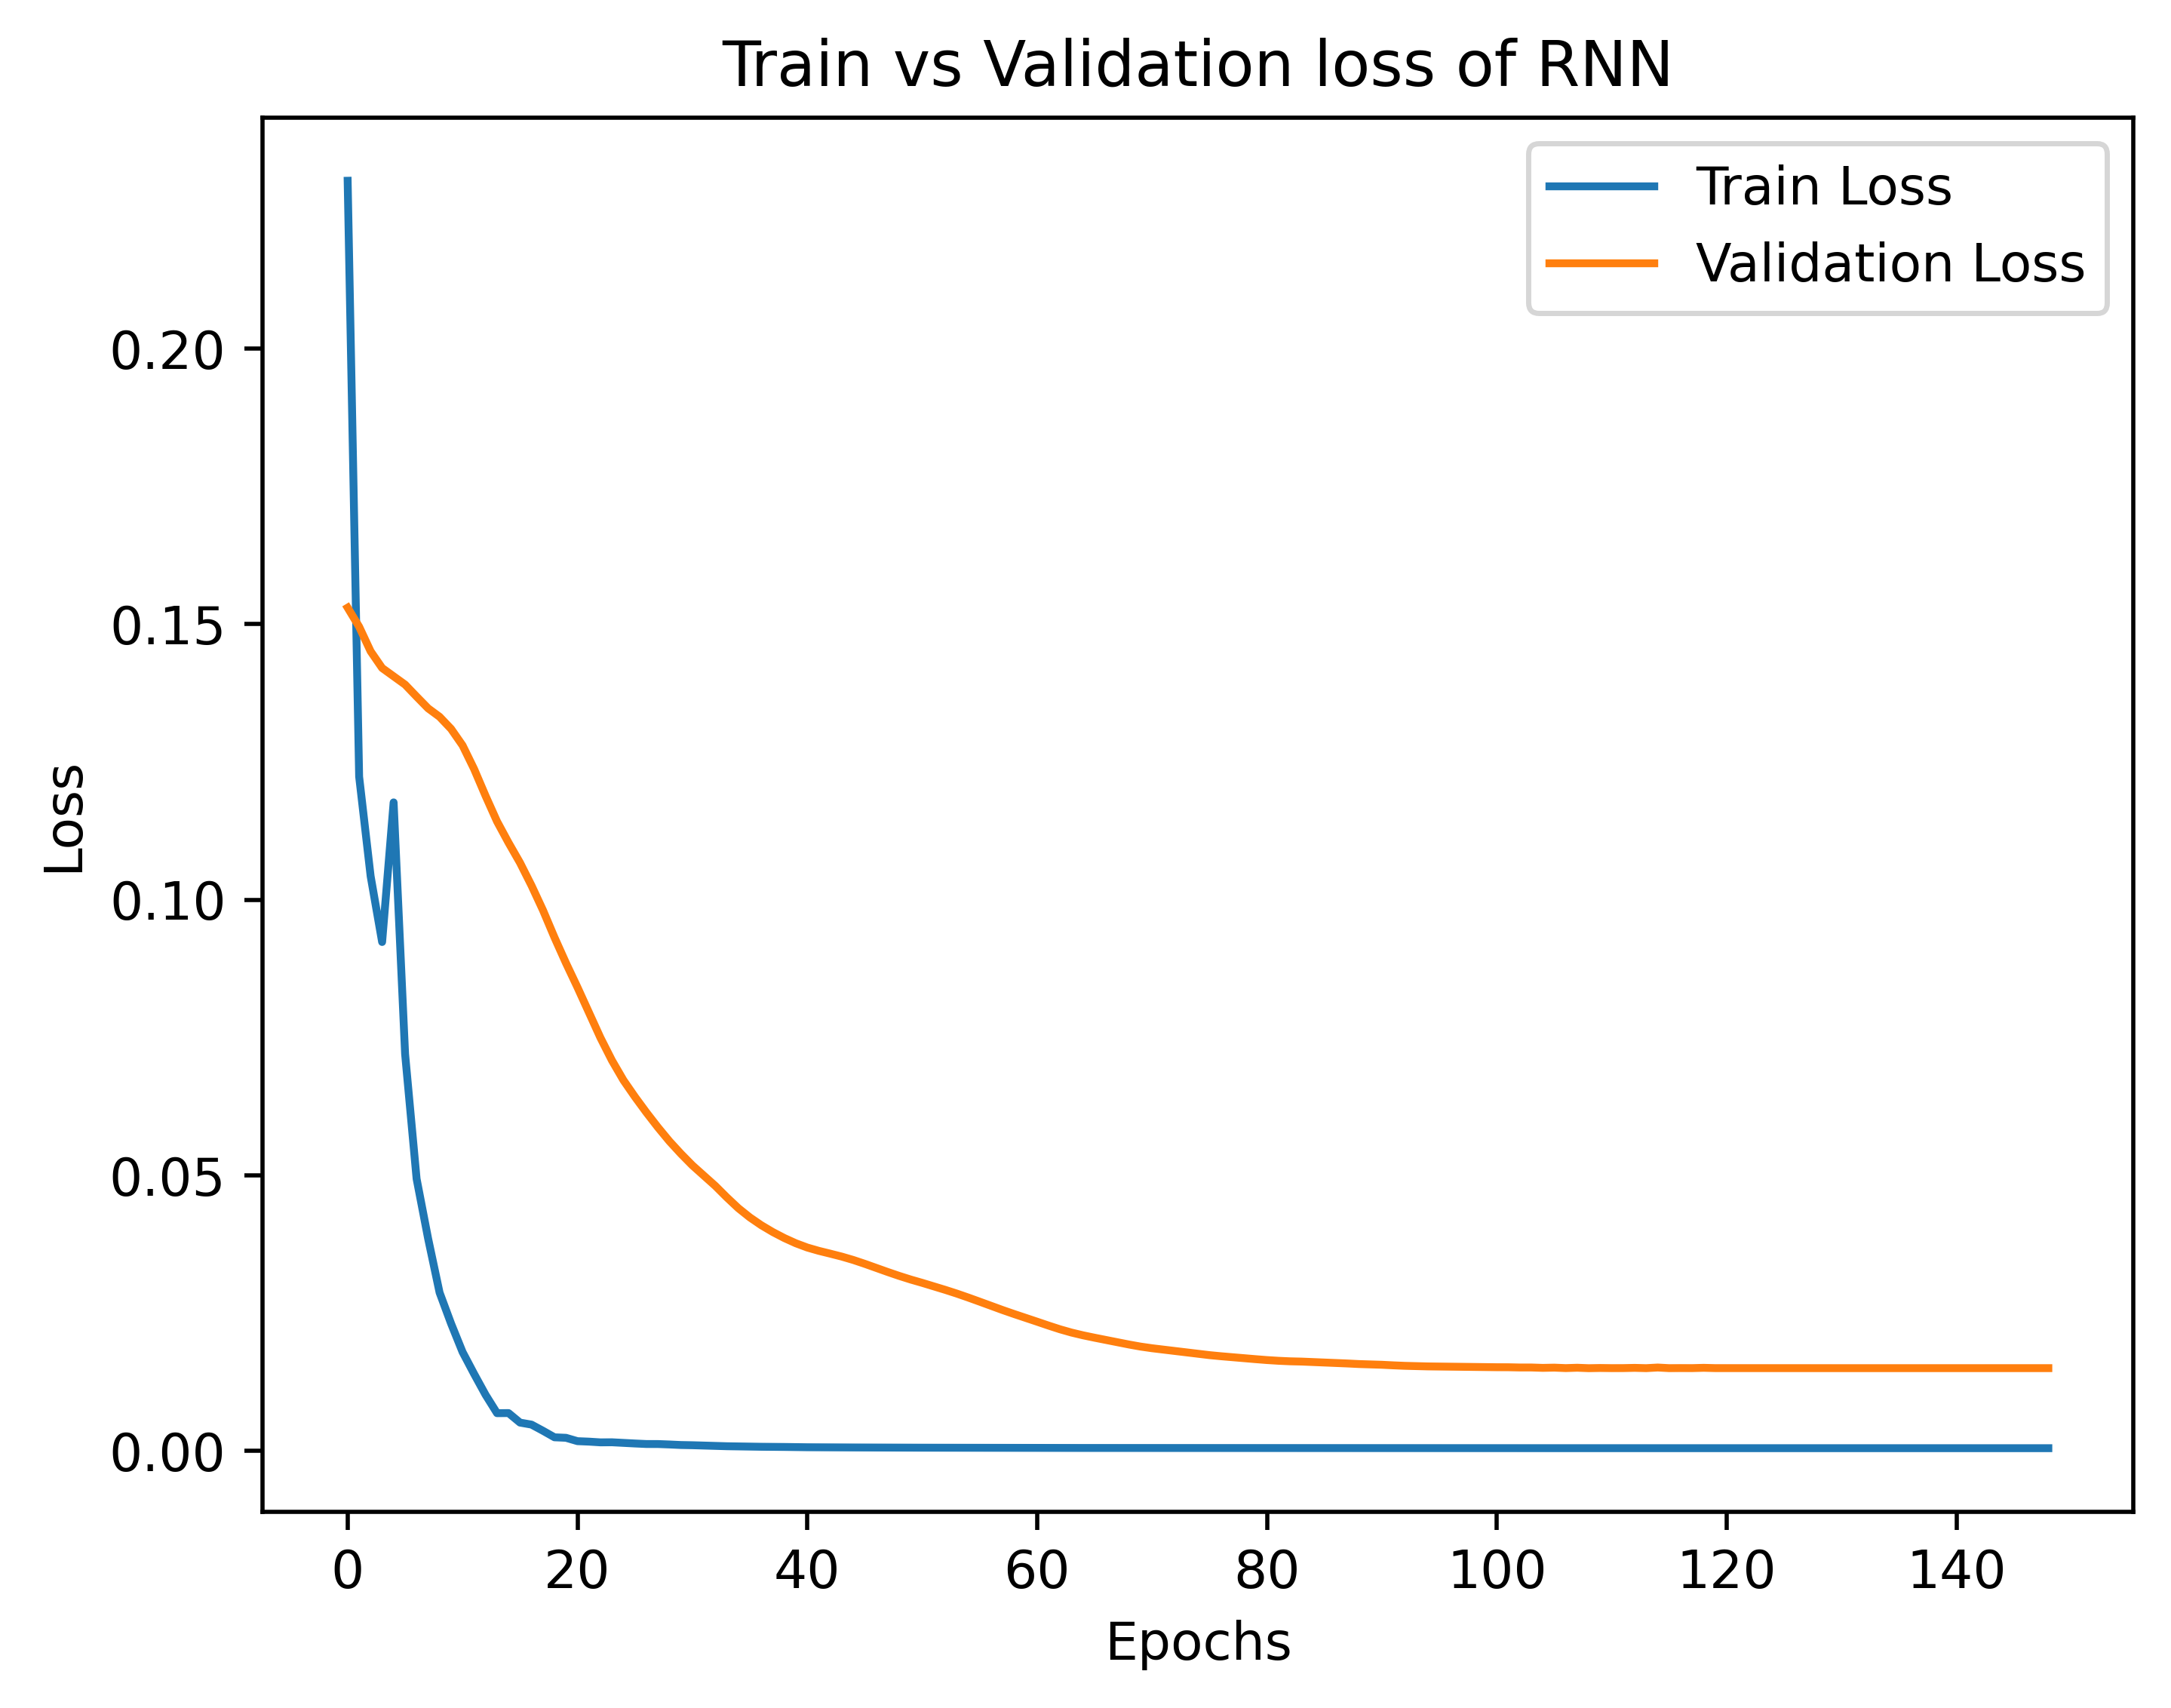

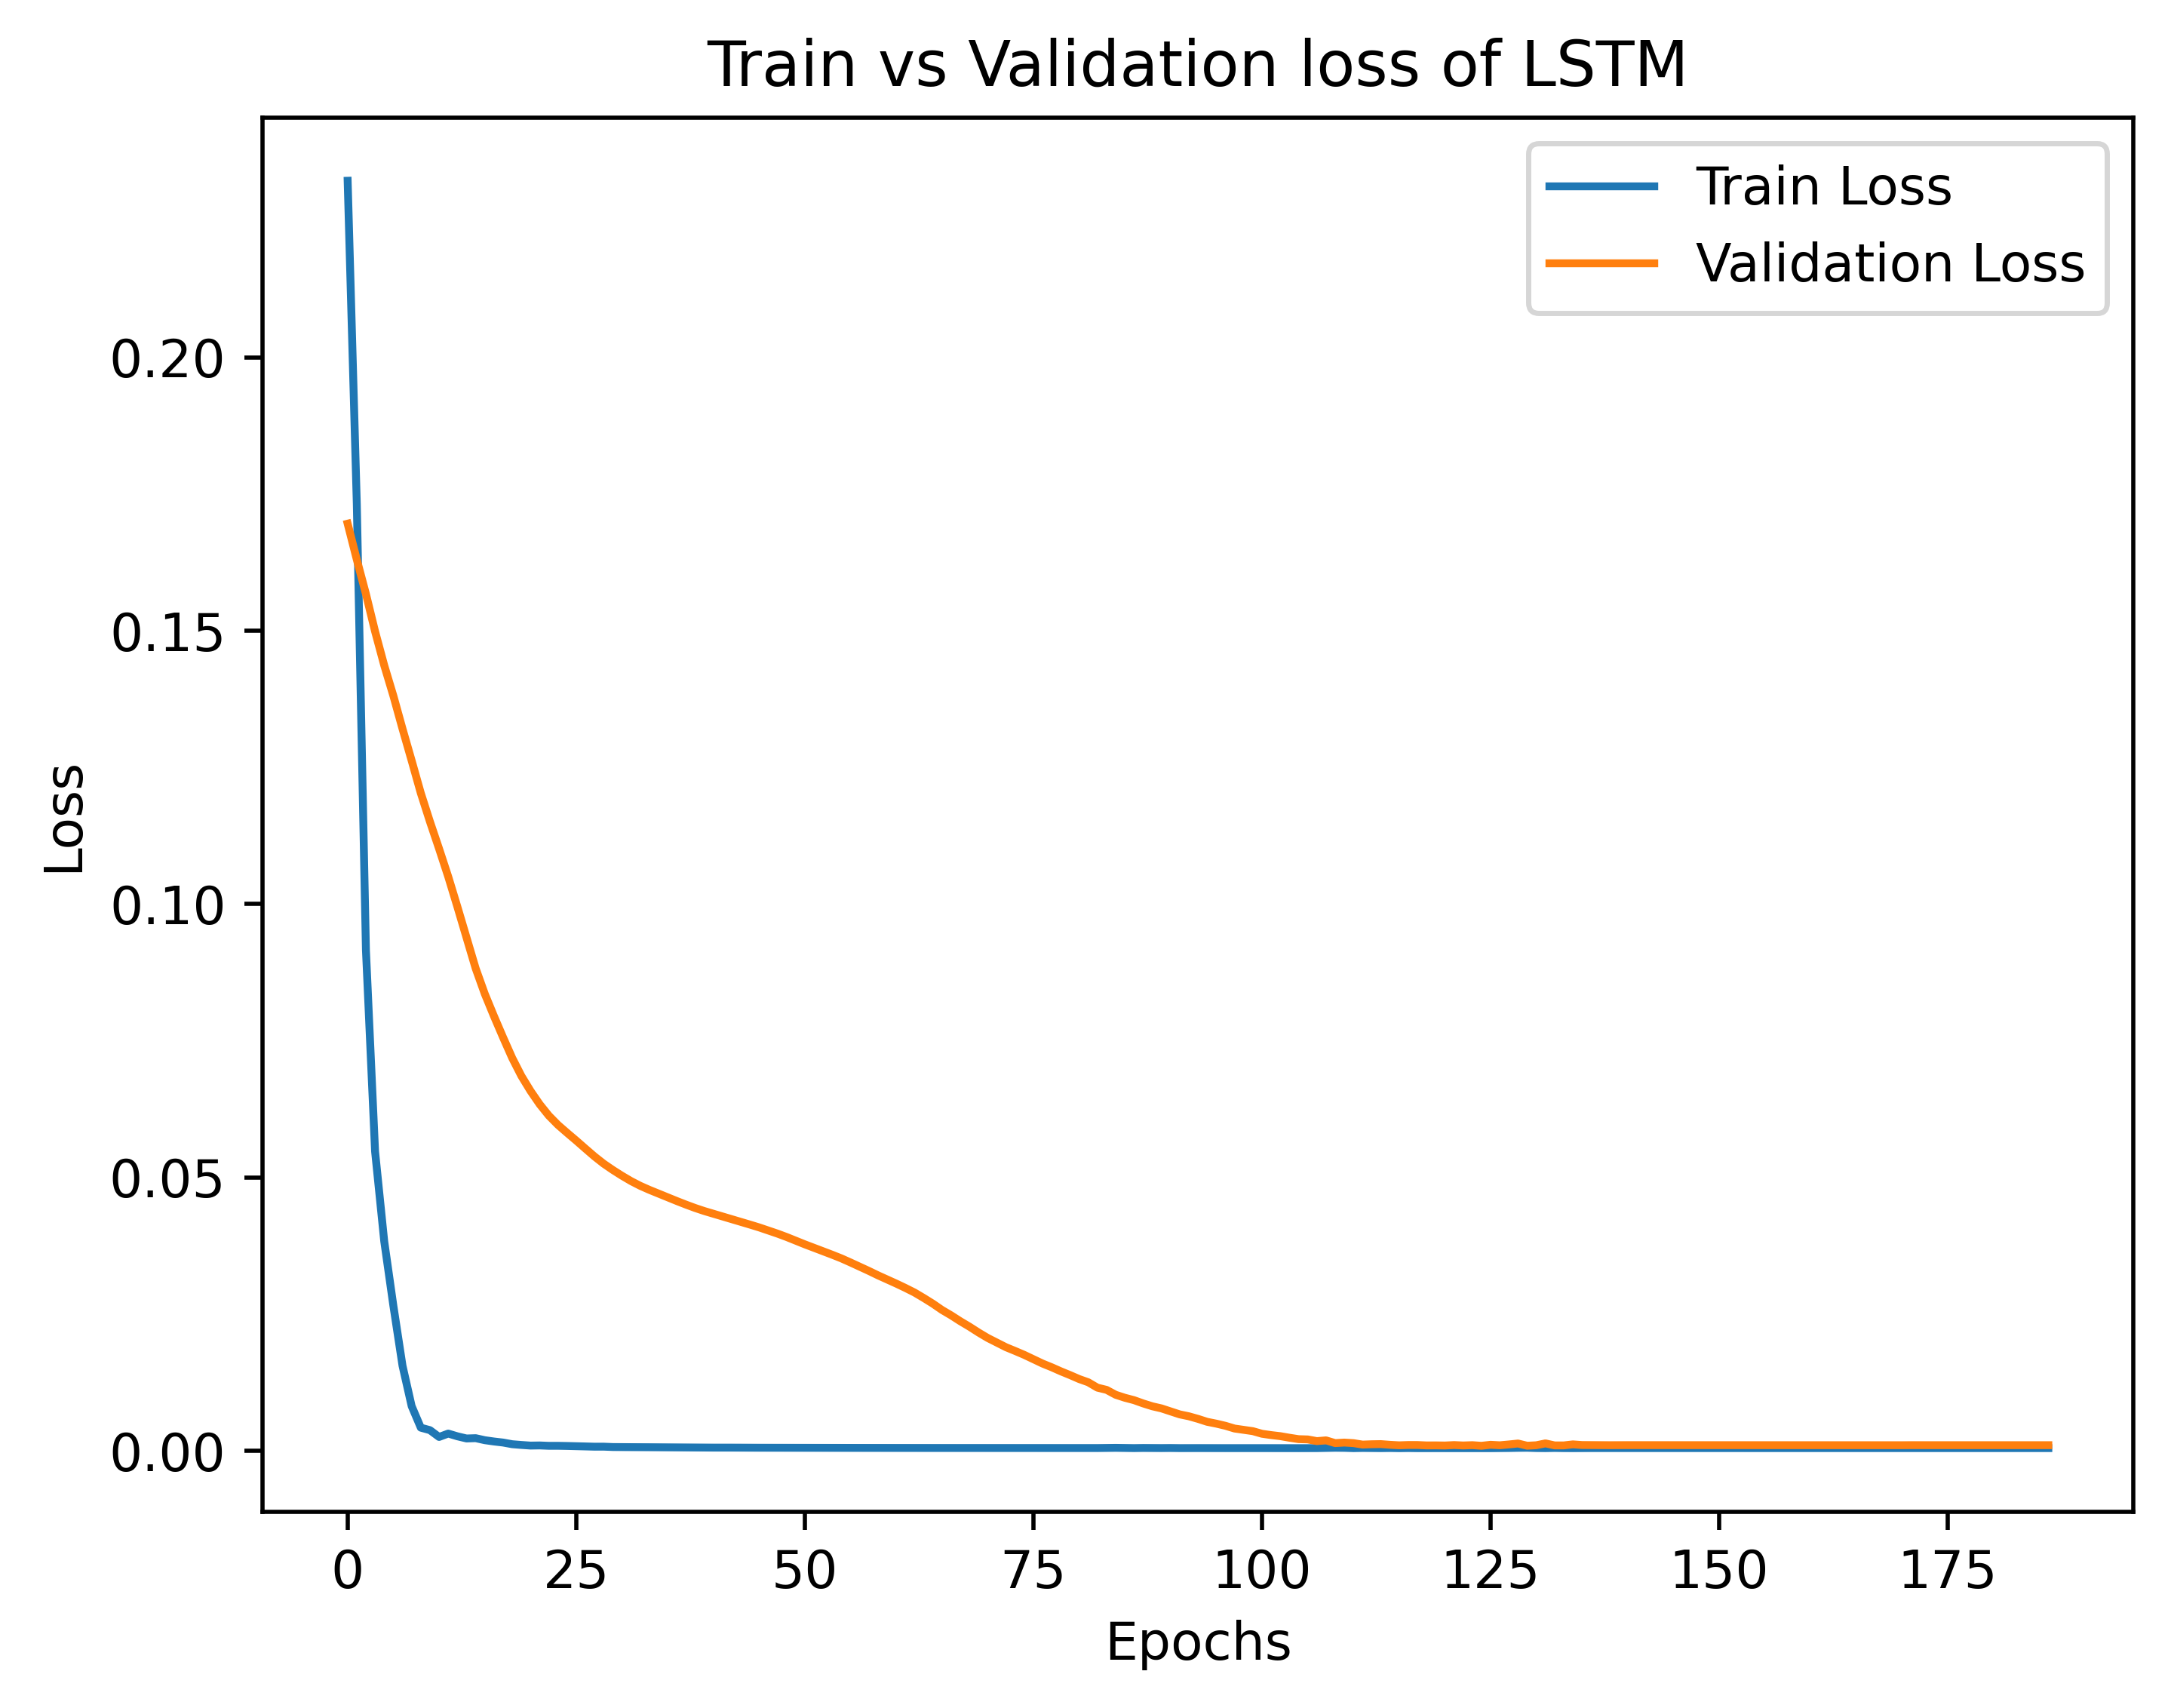

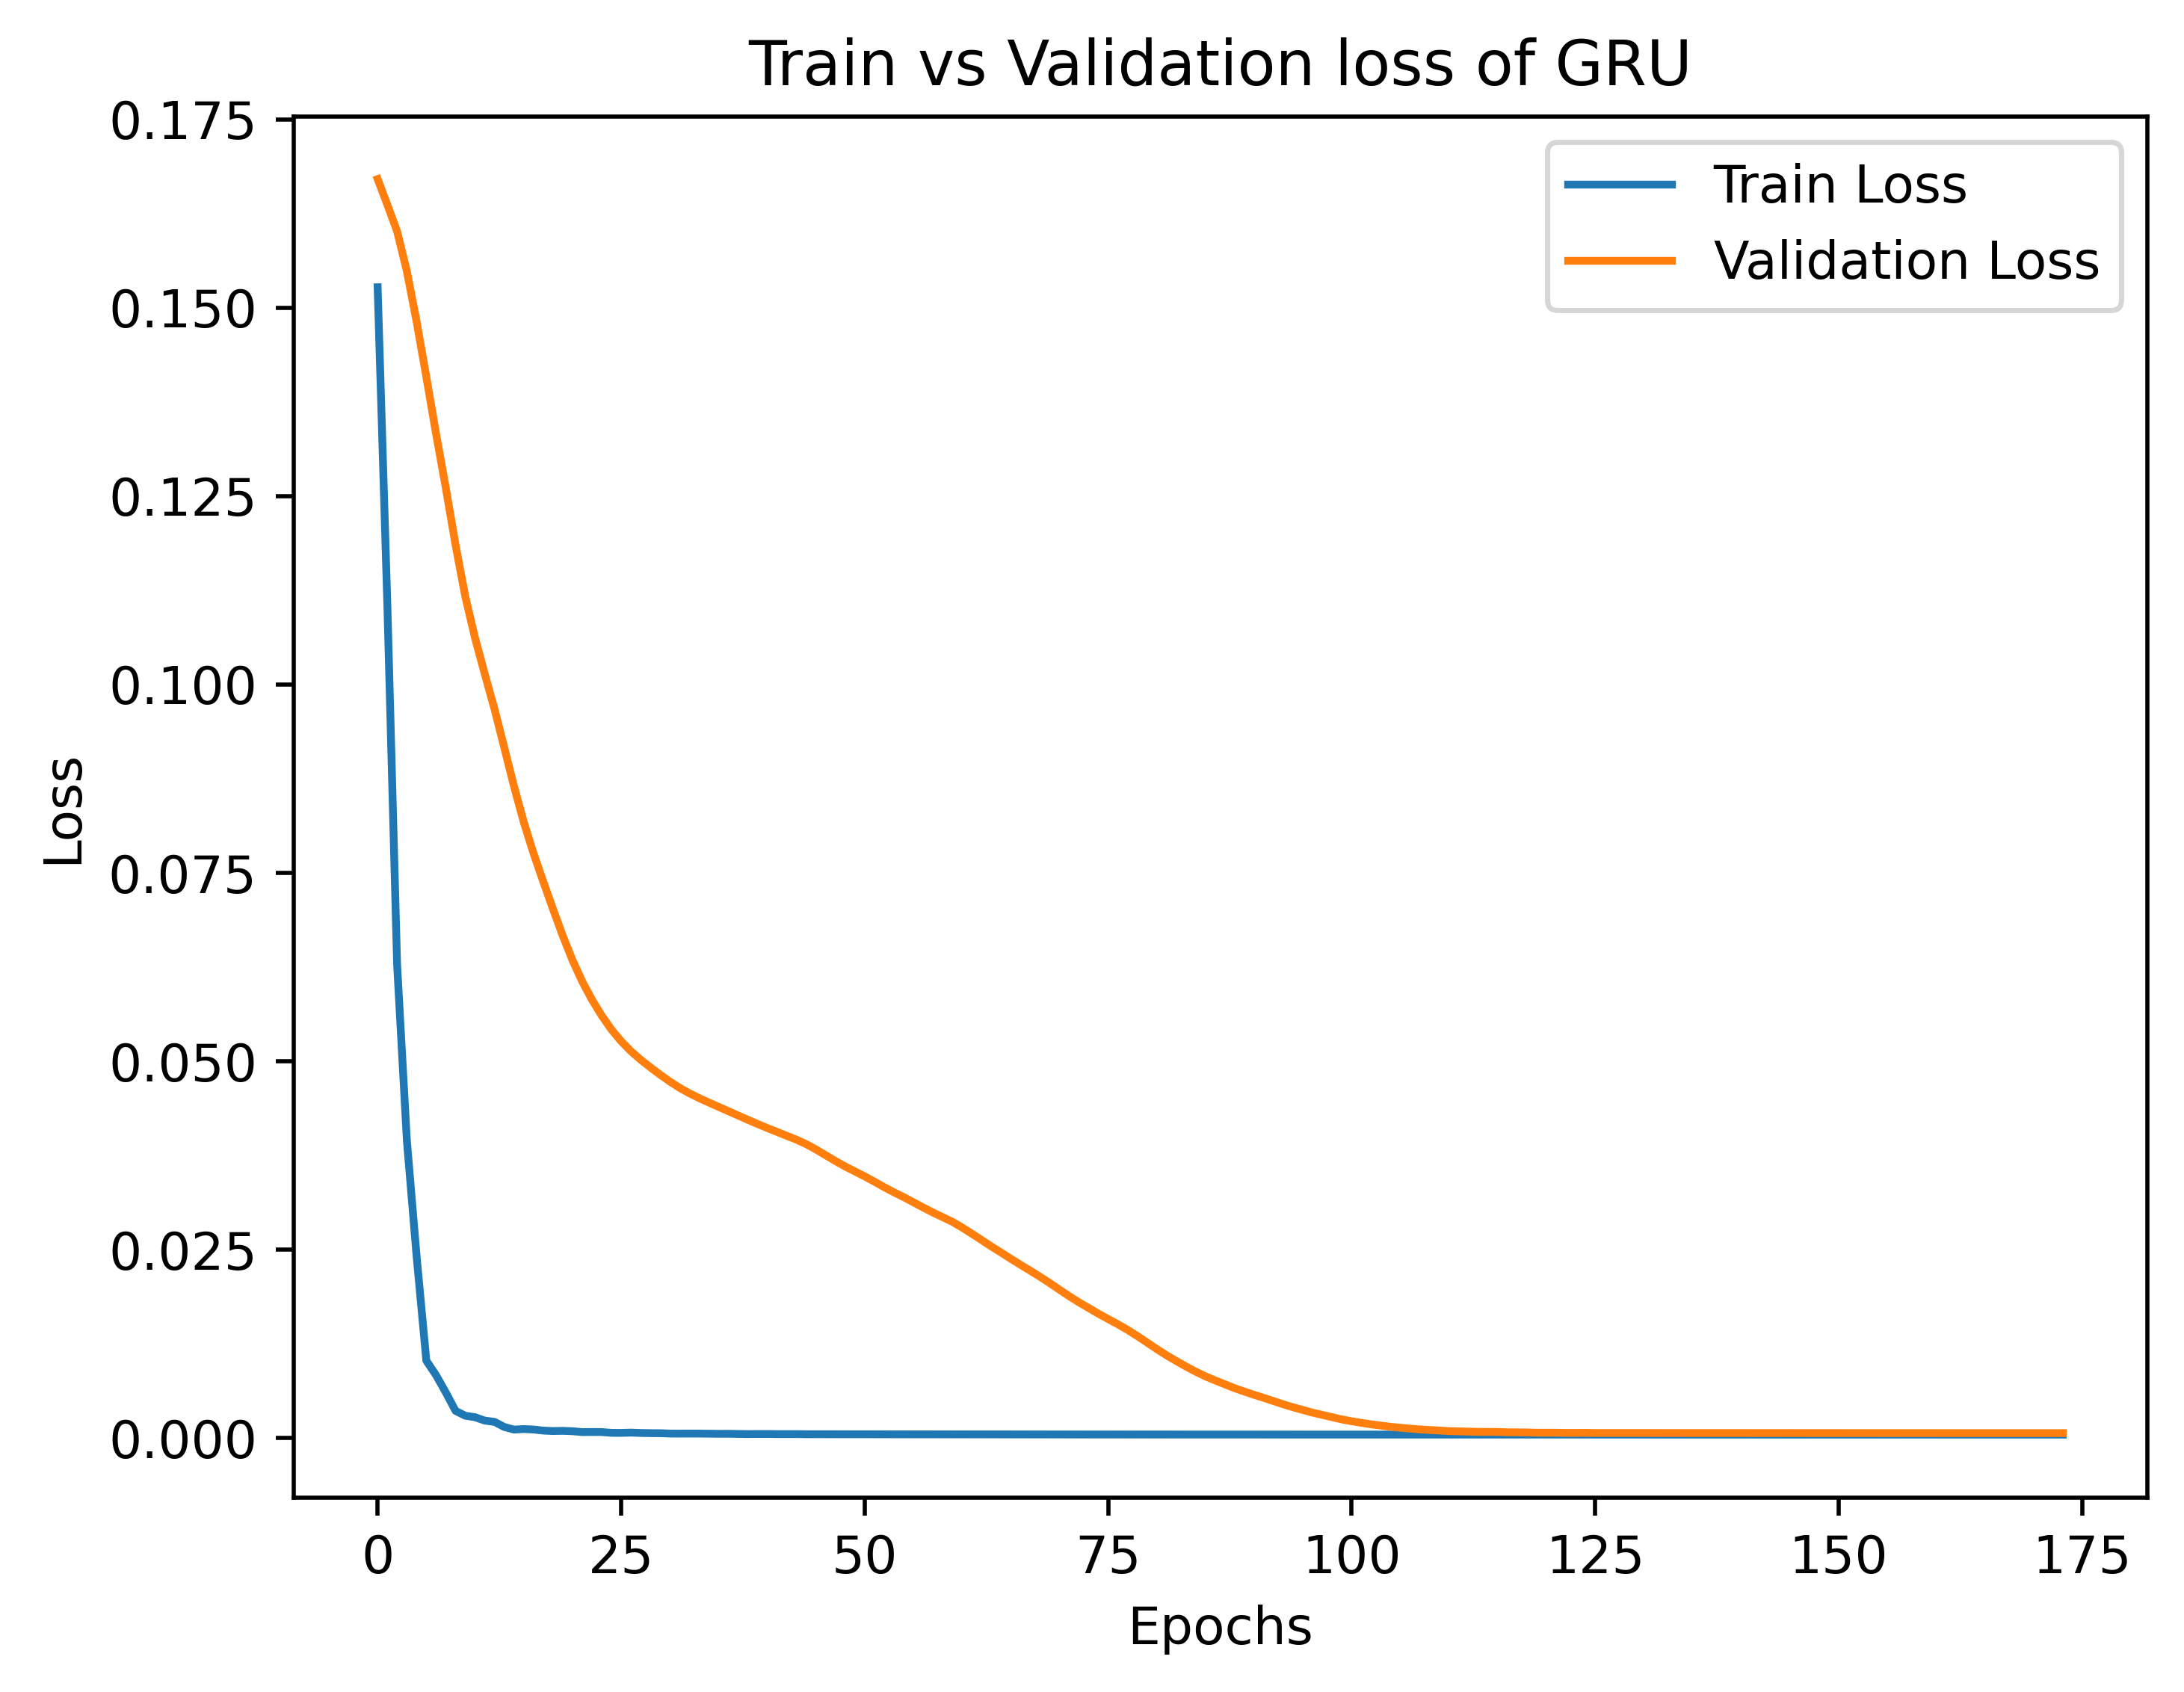

In [30]:
# Show training and validation loss for each model.
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    train_loss = square_matrix(best_row['Train_Loss'])
    val_loss = square_matrix(best_row['Val_Loss'])
    train_loss = np.mean(train_loss, axis=0)
    val_loss = np.mean(val_loss, axis=0)
    epochs = range(train_loss.shape[0])
    plt.plot(epochs, train_loss, label="Train Loss")
    plt.plot(epochs, val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train vs Validation loss of {model_name}")
    plt.show()

### Autoregression

- Generate output one by one

In [31]:
def auto_regression(model, data, y):
    """
    Function for autoregressive output
    """
    initial_sequence = data[0].reshape((1, *data[0].shape)).clone()
    auto_out = initial_sequence.clone()
    actual_out = initial_sequence.clone()
    current_sequence = initial_sequence.clone()
    for i in range(len(y)):
        out = model(current_sequence)
        out = torch.tensor(torch.from_numpy(np.array([out])))
        # Feed the output back to the input.
        auto_out = torch.cat((auto_out, out), dim=1)
        current_sequence = torch.cat((current_sequence[:, 1:, :], out), dim=1)
        # Actual output
        actual_out = torch.cat((actual_out, torch.from_numpy(np.array([[y[i]]]))), dim=1)
    # Return predicted and actual outputs
    return auto_out[0], actual_out[0]
    

In [32]:
# Plot the autoregressive output for each model.
fig, axes = plt.subplots(len(features), 1, figsize=(20, 50), sharex=False, sharey=False)
actual_prices = scaler.inverse_transform(y_test.numpy())
final_results_auto = []
actual_output = None
for model_name, model_class in zip(['RNN', 'LSTM', 'GRU'], [RNNModel, LSTMModel, GRUModel]):
    # Filter the best parameters for this model
    model_results = results_df[results_df['Model'] == model_name]
    best_row = model_results.loc[model_results['Avg_Val_RMSE'].idxmin()]
    best_params = {
        'hidden_size': best_row['Hidden_Size'],
        'num_layers': best_row['Num_Layers'],
        'learning_rate': best_row['Learning_Rate']
    }
    best_weights = best_row['Best_Models'][0]  # Load the best model weights for the first fold
    
    # Initialize and load the model
    best_model = model_class(input_size=len(features), hidden_size=int(best_params['hidden_size']),
                             num_layers=int(best_params['num_layers']), output_size=len(features))
    best_model.load_state_dict(best_weights)
    
    # Evaluate on the test set
    
    best_model.eval()
    with torch.no_grad():
        # Autoregression
        test_output, actual_output = auto_regression(best_model, X_test, y_test)
        predicted_prices = scaler.inverse_transform(test_output.numpy())
        actual_prices = scaler.inverse_transform(actual_output.numpy())
    
    # Calculate RMSE for test set
    criterion = nn.MSELoss()
    test_rmse = np.sqrt(criterion(test_output, actual_output).item())
    test_mae = torch.mean(np.abs(test_output-actual_output)).item()
    test_r2 = r2_score(test_output, actual_output).item()
    print(f"Test RMSE for {model_name}: {test_rmse:.4f}")
    print(f"Test MAE for {model_name}: {test_mae:.4f}")
    print(f"Test R2 for {model_name}: {test_r2:.4f}")
    final_results_auto.append({
        'Model': model_name,
        'Hidden size': best_row['Hidden_Size'],
        '#Layers': best_row['Num_Layers'],
        'Learning rate': best_row['Learning_Rate'],
        'Avg Val RMSE': best_row['Avg_Val_RMSE'],
        'Autoregressive Test RMSE': test_rmse,
        'Autoregressive Test MAE': test_mae,
        'Autoregressive Test R2': test_r2
    })
    # Plot the predictions
    
    axes.plot(df_test['Date'], predicted_prices[:, 0], label=f'{model_name} Predictions (RMSE: {test_rmse:.4f})')
    

    # Plot actual prices
    if model_name == 'GRU': # Show actual values on the last plot
        axes.plot(df_test['Date'], actual_prices[:, 0], label=f'Actual {features[0]}', color='blue', linewidth=2)
    
    # Customize the plot
    axes.set_title(f'Test Data: Actual vs Predicted {features[0]} for RNN, LSTM, GRU via Autoregression')
    axes.set_xlabel('Date')
    axes.tick_params(axis='x', rotation=30)
    axes.set_ylabel(f'{features[0]}')
    axes.legend()
    axes.grid()
plt.show()


/tmp/ipykernel_24/3714688321.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(torch.from_numpy(np.array([out])))
/tmp/ipykernel_24/3714688321.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(torch.from_numpy(np.array([out])))
/tmp/ipykernel_24/3714688321.py:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = torch.tensor(torch.from_numpy(np.array([out])))


Test RMSE for RNN: 0.0171
Test MAE for RNN: 0.0120
Test R2 for RNN: -0.2095
Test RMSE for LSTM: 0.0131
Test MAE for LSTM: 0.0096
Test R2 for LSTM: 0.2813
Test RMSE for GRU: 0.0229
Test MAE for GRU: 0.0143
Test R2 for GRU: -1.1761


In [33]:
fr_auto = pd.DataFrame(final_results_auto)
fr_auto

Model  Hidden size  #Layers  Learning rate  Avg Val RMSE  \
0   RNN          128        2          0.001      0.072783   
1  LSTM          256        2          0.001      0.024571   
2   GRU          256        1          0.001      0.021972   

   Autoregressive Test RMSE  Autoregressive Test MAE  Autoregressive Test R2  
0                  0.017059                 0.012026               -0.209537  
1                  0.013150                 0.009585                0.281274  
2                  0.022881                 0.014280               -1.176131